## SDXL-v1.0 classic fine tuning example
> aka native text2image training for whole model
* This is an experiment for fine tune SD-XL-v1.0 with Kohya-ss unpublished sd-scripts.
* Classtic fine tuning used [Linaqruf's hitokomoru dataset](https://huggingface.co/datasets/Linaqruf/locon-dataset/tree/main), total 98 pictures (regarding how to prepare such dataset, check [content from kohya-ss github](https://github.com/kohya-ss/sd-scripts/blob/main/docs/train_README-ja.md#%E3%83%A1%E3%82%BF%E3%83%87%E3%83%BC%E3%82%BF%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB%E3%81%AE%E4%BD%9C%E6%88%90))
* Training method also refered to the descripton of [Linaqruf/hitokomoru-diffusion-v2](https://huggingface.co/Linaqruf/hitokomoru-diffusion-v2), but quite different, since it is SDXL
* Training scripts used [sdxl_train.py from kohya-ss/sd-scripts](https://github.com/kohya-ss/sd-scripts/blob/sdxl/sdxl_train.py), images were processed use [Aspect Ratio Bucketing](https://github.com/NovelAI/novelai-aspect-ratio-bucketing)
* Even though kohya-ss/sd-scripts now supported multi-gpu training by leveraging [Accelerate's --multi_gpu feature](https://huggingface.co/docs/accelerate/package_reference/cli#accelerate-launch),  the example didn't use it, regarding multi-gpu training pls refer to "sdxl-classic-finetune-text2image-decoupled-notebook.ipynb.ipynb" notebook
* Tested with ml.g5.4xlarge SageMaker notebook instance, which provides 1 NVIDIA A10G GPUs

## 1. Install dependencies

In [ ]:
!git clone -b sdxl https://github.com/kohya-ss/sd-scripts
%cd sd-scripts/
!sed -i 's/diffusers\[torch\]==0\.18\.2/diffusers[torch]==0.19.3/g; s/tensorboard==2\.10\.1/tensorboard==2.11.0/g' requirements.txt
!pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 --index-url https://download.pytorch.org/whl/cu118 --no-cache-dir
!pip install -U -r requirements.txt
!pip install xformers==0.0.20 wandb natsort bitsandbytes==0.41.1 

In [ ]:
# fix some warnings and bugs poping up from sagemaker notebook

!pip install -U tensorflow
!sudo rm -rf /lib64/libstdc++.so.6 /lib64/libstdc++.so.6
!sudo ln -s /home/ec2-user/anaconda3/envs/python3/lib/libstdc++.so.6 /lib64/libstdc++.so.6

import os
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

## 2. Initialize training environment 

In [ ]:
from accelerate.utils import write_basic_config
write_basic_config()

Refer "dataset-example.toml" to configure your own .toml file

In [ ]:
%%writefile dataset.toml
[general]
enable_bucket = true
shuffle_caption = true
keep_tokens = 0
# color_aug = true

# Classic fine tuning based datasets
[[datasets]]
resolution = 1024
min_bucket_reso = 640
max_bucket_reso = 1536
bucket_reso_steps = 32
batch_size = 4

  [[datasets.subsets]]
  image_dir = './images/hitokomoru'
  metadata_file = './images/hitokomoru/meta_clean.json'

In [ ]:
%%writefile sample_prompts.txt
# prompt 1
1girl, solo, looking at viewer, smile, short hair, bangs, hair ornament, closed mouth, purple eyes, upper body, braid, white hair, japanese clothes, wings, hair flower, kimono, hair over one eye, from side, looking to the side, kanzashi, chrysanthemum --n ugly, deformed, disfigured --w 832 --h 1216 --d 3129467234 --l 7.5 --s 20

# prompt 2
1girl, solo, looking at viewer, smile, short hair, bangs, hair ornament, closed mouth, purple eyes, upper body, braid, white hair, japanese clothes, wings, hair flower, kimono, hair over one eye, from side, looking to the side, kanzashi, chrysanthemum --n ugly, deformed, disfigured --w 832 --h 1216 --d 3129467235 --l 7.5 --s 20


In [ ]:
MODEL_NAME = "stabilityai/stable-diffusion-xl-base-1.0"
DATASET_CONFIG = "./dataset.toml"
TRAIN_DATA_DIR = "./images/hitokomoru"
IMAGES_OUTPTS = "./images/outputs"
MODEL_OUTPTS = "./output"

!mkdir -p $TRAIN_DATA_DIR $IMAGES_OUTPTS $MODEL_OUTPTS
print(MODEL_NAME)

## 3. Prepare training dataset

### 3.1 Download image dataset and organize image files

In [7]:
!wget -q https://huggingface.co/datasets/Linaqruf/locon-dataset/resolve/main/hitokomoru_locon_dataset.zip

In [8]:
import os
import shutil
import zipfile

zip_file = 'hitokomoru_locon_dataset.zip'
target_dir = TRAIN_DATA_DIR
temp_dir = target_dir+'/temp'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

bottom_dir = None
for root, dirs, files in os.walk(temp_dir):
    if not dirs:
        if bottom_dir is None:
            bottom_dir = root
        elif len(root.split(os.sep)) > len(bottom_dir.split(os.sep)):
            bottom_dir = root
        
for root, dirs, files in os.walk(bottom_dir):
    for file in files:
        if not file.endswith('.npz'):
            source_file = os.path.join(root, file)
            target_file = os.path.join(target_dir, file)
            shutil.copy(source_file, target_file)
    
shutil.rmtree(temp_dir)
os.remove('./hitokomoru_locon_dataset.zip')

### 3.2 Prepare classic fine tuning necessary [metadata file](https://github.com/kohya-ss/sd-scripts/blob/main/train_README-ja.md#%E3%82%AD%E3%83%A3%E3%83%97%E3%82%B7%E3%83%A7%E3%83%B3%E3%81%A8%E3%82%BF%E3%82%B0%E6%83%85%E5%A0%B1%E3%81%AE%E5%89%8D%E5%87%A6%E7%90%86)

In [ ]:
!python ./finetune/merge_captions_to_metadata.py --full_path $TRAIN_DATA_DIR $TRAIN_DATA_DIR/meta_cap.json

In [ ]:
!python ./finetune/merge_dd_tags_to_metadata.py --full_path $TRAIN_DATA_DIR --in_json $TRAIN_DATA_DIR/meta_cap.json $TRAIN_DATA_DIR/meta_cap_dd.json

In [ ]:
!python ./finetune/clean_captions_and_tags.py $TRAIN_DATA_DIR/meta_cap_dd.json $TRAIN_DATA_DIR/meta_clean.json

## 3. Train model
* Enable multi GPU training, you can enable by adding "--multi_gpu" flag  
* Refer to [train_util.py](https://github.com/kohya-ss/sd-scripts/blob/main/library/train_util.py) for all of configurations you can change

In [ ]:
!accelerate launch sdxl_train.py \
   --pretrained_model_name_or_path=$MODEL_NAME \
   --output_dir=$MODEL_OUTPTS \
   --output_name="classic_finetune_hitokomoru_sdxl" \
   --dataset_config=$DATASET_CONFIG \
   --learning_rate=1e-5 --max_train_steps=2500 \
   --max_token_length=225 \
   --save_every_n_steps=500 \
   --xformers --optimizer_type="AdamW8bit" --gradient_checkpointing \
   --no_half_vae \
   --mixed_precision="bf16" \
   --full_bf16 \
   --cache_latents_to_disk \
   # --cache_text_encoder_outputs_to_disk \
   --sample_every_n_steps=500 \
   --sample_prompts="./sample_prompts.txt" \
   --sample_sampler="euler_a" \
   # --save_model_as="safetensors" \
   --logging_dir="./logs" \
   --log_with="all" \
   --log_tracker_name="classic_finetune_hitokomoru_sdxl" \
   --wandb_api_key="af5d2776d08d98fbb27d05043a19cc2dca9d3b63" # register a user via https://wandb.ai and get an API key 

## 4. Mode inference testing

In [ ]:
from natsort import natsorted
from glob import glob
import os

WEIGHTS_DIR = natsorted(glob(MODEL_OUTPTS + os.sep + "*"))[0]

print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")    

In [ ]:
import torch
import datetime

from diffusers import DiffusionPipeline, EulerAncestralDiscreteScheduler, StableDiffusionPipeline

model_dir = WEIGHTS_DIR
refiner_model = MODEL_NAME.replace('base', 'refiner')

scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")
generator = torch.Generator(device="cuda")

base_pipe = DiffusionPipeline.from_pretrained(model_dir, torch_dtype=torch.float16, variant="fp16").to("cuda")
refiner_pipe = DiffusionPipeline.from_pretrained(refiner_model, text_encoder_2=base_pipe.text_encoder_2, vae=base_pipe.vae, torch_dtype=torch.float16, variant="fp16").to("cuda")

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

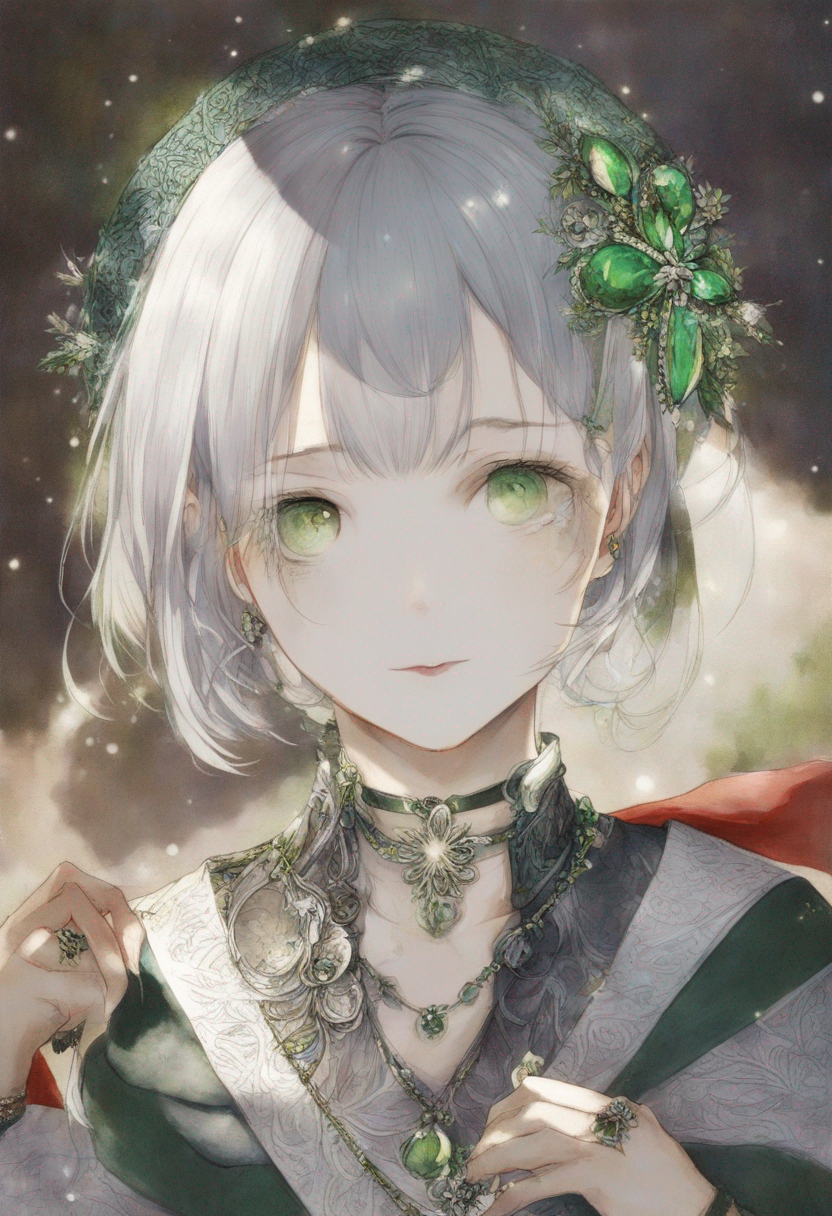

./images/outputs/5332566723065096_2023-08-25 20:49:51.png



  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

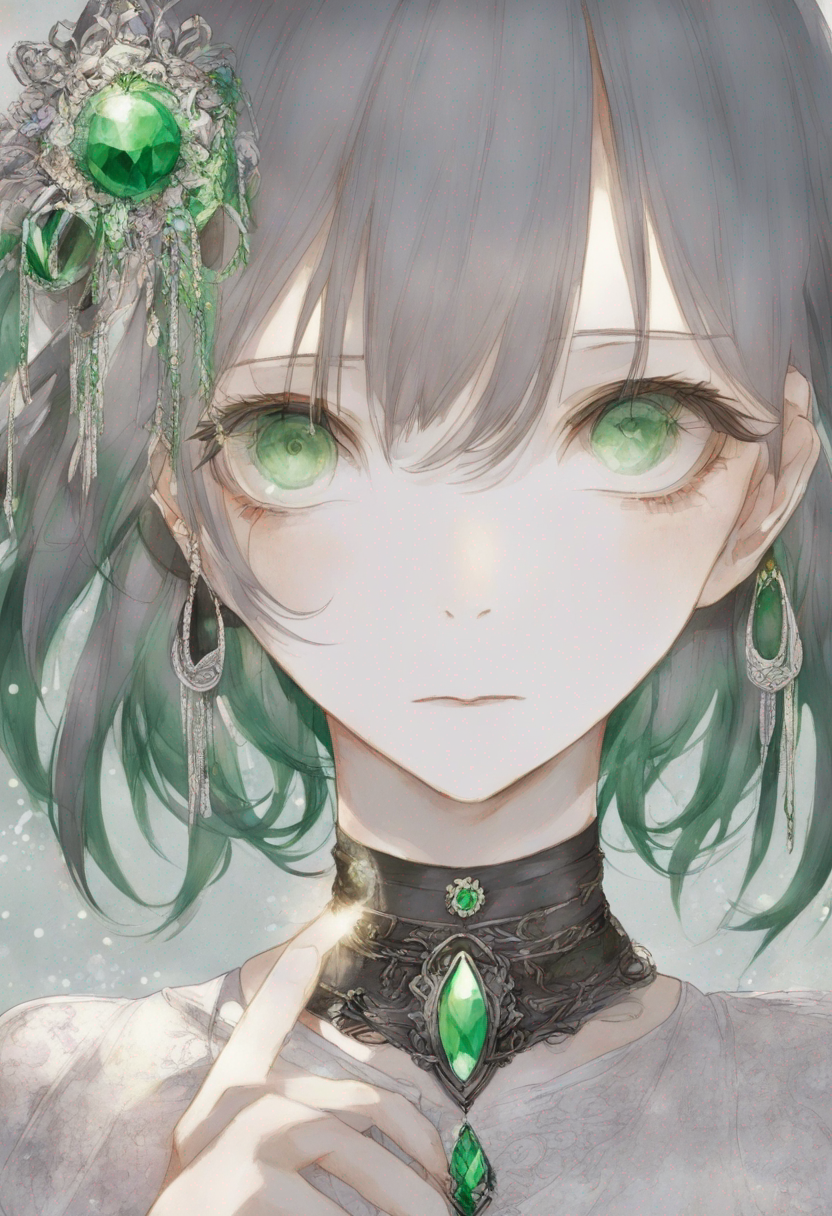

./images/outputs/1617620205163632_2023-08-25 20:49:59.png


Seeds for generating images: [5332566723065096, 1617620205163632]



In [15]:
prompt = "1girl, solo, looking at viewer, jewelry, hair ornament, hair between eyes, choker, parted lips, green eyes, bangs, short hair, grey hair, upper body, portrait"
negative_prompt = "ugly, disfigured, deformed"

num_images = 2
seeds = []
for _ in range(num_images):
    seed = generator.seed()
    seeds.append(seed)
    generator = generator.manual_seed(seed)
    
    image = base_pipe(
        prompt=prompt, 
        negative_prompt=negative_prompt,
        height=1216,
        width=832,
        num_images_per_prompt=1,
        num_inference_steps=20,
        guidance_scale=7.5,
        denoising_end=0.8,
        generator = generator,
        output_type="latent",
    ).images
    
    # Use refiner model
    image = refiner_pipe(
        prompt=prompt,
        num_inference_steps=20,
        denoising_start=0.8,
        image=image,
    ).images[0]
    
    display(image)
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    file_path = IMAGES_OUTPTS + "/" + str(seed) + "_" + str(now) + ".png"
    print(file_path + "\n")
    image.save(file_path)
    
# print(seeds)
print(f"\nSeeds for generating images: {seeds}\n")

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

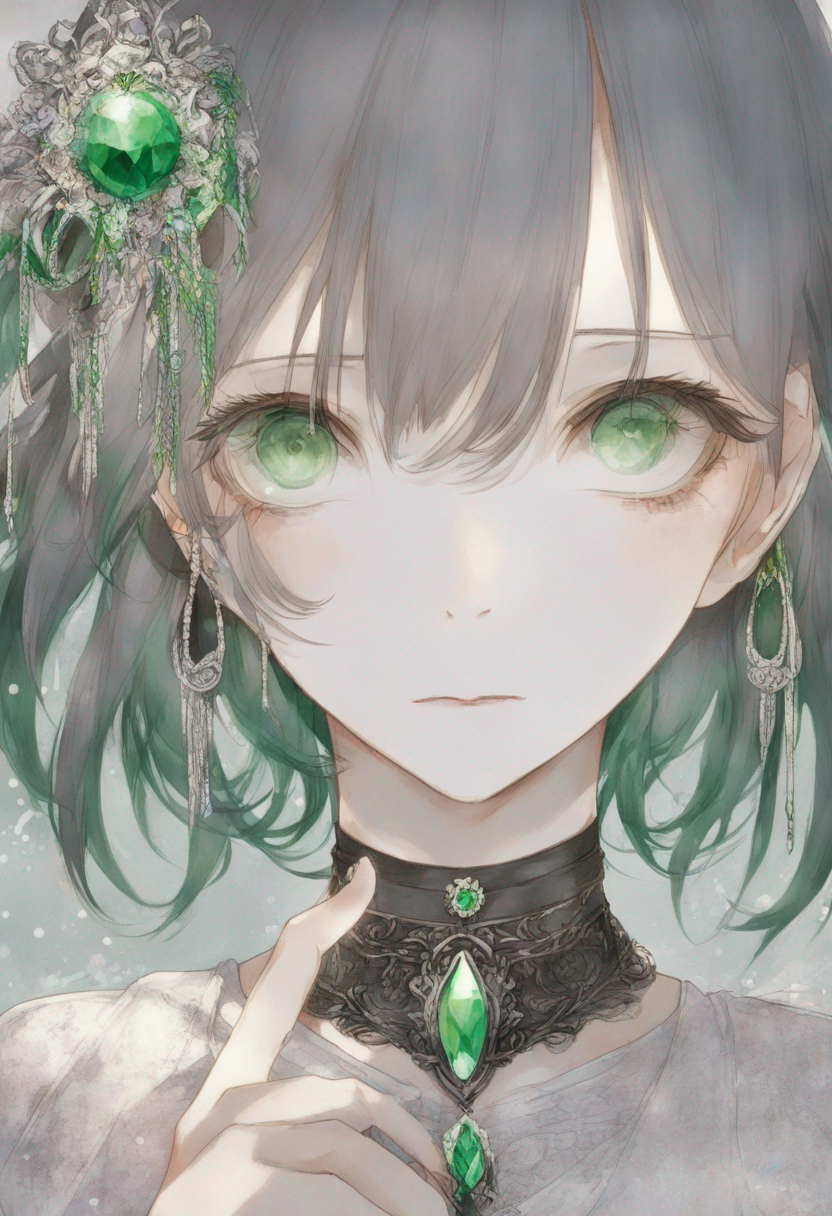

In [16]:
# Comment below codes, if you don't want to produce the same images again

seed = seeds[1] # use the second seed
generator.manual_seed(seed)

image = base_pipe(
    prompt=prompt, 
    negative_prompt=negative_prompt,
    height=1216,
    width=832,
    num_images_per_prompt=1,
    num_inference_steps=20,
    guidance_scale=7,
    denoising_end=0.8,
    generator = generator,
    output_type="latent",
).images
    
# Use refiner model
image = refiner_pipe(
    prompt=prompt,
    num_inference_steps=20,
    denoising_start=0.8,
    image=image,
).images[0]

display(image)

In [ ]:
# # Comment below codes out, if you don't want to generate ckpt file for web UI

!wget -q https://raw.githubusercontent.com/huggingface/diffusers/main/scripts/convert_diffusers_to_original_sdxl.py
ckpt_path = WEIGHTS_DIR + "/model.safetensors"
half_arg = ""
# Whether to convert to fp16, takes half the space (2GB).
fp16 = True # {type: "boolean"}
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_sdxl.py --model_path $WEIGHTS_DIR  --checkpoint_path $ckpt_path $half_arg --use_safetensors
print(f"[*] Converted ckpt saved at {ckpt_path}")